#Задание
**Классификация изображений: Cats vs Dogs**

Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по [ссылке](https://github.com/a4tunado/lectures/tree/master/006). Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3. [Датасет](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

# **Решение на базе модели VGG16**

In [ ]:
import cv2
import numpy as np
import re
import keras
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from tqdm import tqdm

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download dogs-vs-cats-redux-kernels-edition
# Для загрузки датасетов, не являющихся частью к-л конкурса:
# !kaggle datasets download <name-of-dataset>
# Например, для датасета на странице https://www.kaggle.com/arenagrenade/the-complete-pokemon-images-data-set:
# !kaggle datasets download arenagrenade/the-complete-pokemon-images-data-set

 98% 797M/814M [00:04<00:00, 184MB/s]
100% 814M/814M [00:04<00:00, 174MB/s]


In [ ]:
!unzip dogs-vs-cats-redux-kernels-edition
!unzip test
!unzip train

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

## Функции загрузки данных

In [ ]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('train/*.jpg')
test_files = glob('test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

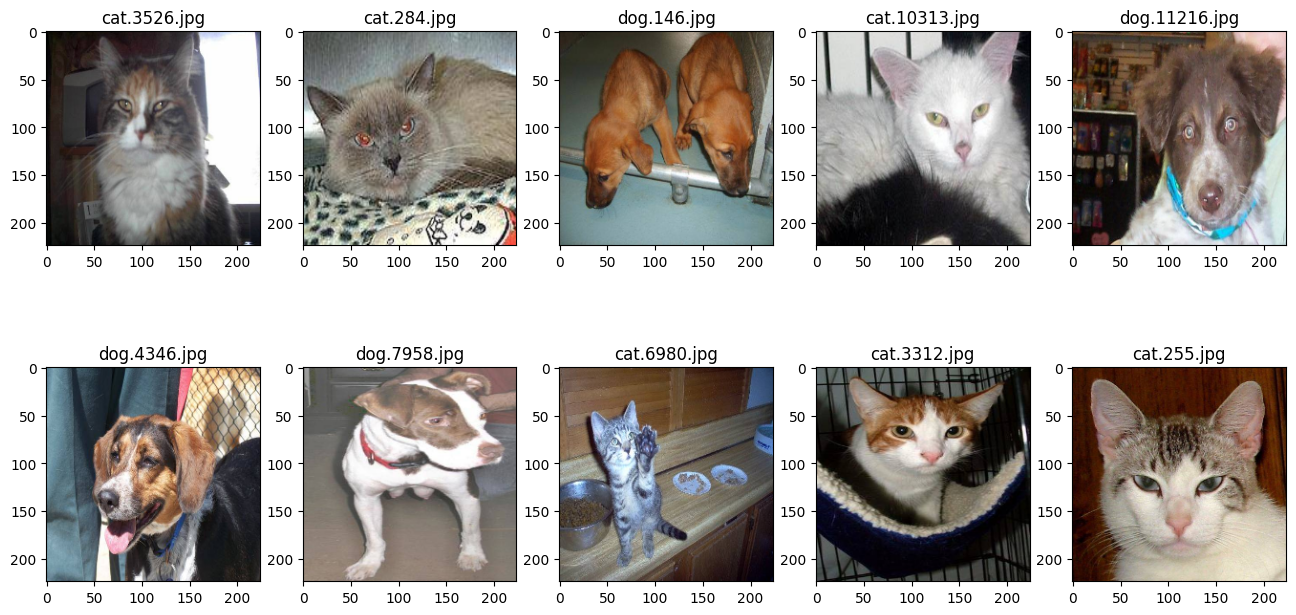

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [ ]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)

x = keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          kernel_regularizer=keras.regularizers.l1(1e-4))(x)

model = keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [ ]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=keras.metrics.BinaryAccuracy())

In [ ]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=30,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/30
10/10 [==============================] - 5s 551ms/step - loss: 1.1069 - binary_accuracy: 0.9531 - val_loss: 0.0013 - val_binary_accuracy: 1.0000
Epoch 2/30
10/10 [==============================] - 2s 187ms/step - loss: 0.7968 - binary_accuracy: 0.9625 - val_loss: 0.0013 - val_binary_accuracy: 1.0000
Epoch 3/30
10/10 [==============================] - 2s 191ms/step - loss: 0.2531 - binary_accuracy: 0.9688 - val_loss: 0.0013 - val_binary_accuracy: 1.0000
Epoch 4/30
10/10 [==============================] - 2s 192ms/step - loss: 0.1699 - binary_accuracy: 0.9719 - val_loss: 0.0013 - val_binary_accuracy: 1.0000
Epoch 5/30
10/10 [==============================] - 2s 190ms/step - loss: 0.5618 - binary_accuracy: 0.9625 - val_loss: 0.0013 - val_binary_accuracy: 1.0000
Epoch 6/30
10/10 [==============================] - 2s 190ms/step - loss: 0.1136 - binary_accuracy: 0.9812 - val_loss: 0.0013 - val_binary_accuracy: 1.0000
Epoch 7/30
10/10 [==============================] - 3s 262ms/ste

In [ ]:
%%time
test_pred_tmp = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 120s 10ms/step
CPU times: user 3min 4s, sys: 3.82 s, total: 3min 8s
Wall time: 2min 21s


In [ ]:
# Сохранение результатов в файл для загрузки на kaggle.com:
import re

with open('submit_tmp.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred_tmp):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

# **Получен лосс 0,22869.**

# **Решение на базе модели InceptionV3**

In [ ]:
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3

In [ ]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (299, 299)  # размер входного изображения сети

train_files = glob('train/*.jpg')
test_files = glob('test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return inception_v3.preprocess_input(img)  # предобработка для InceptionV3

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [ ]:
base_model_2 = InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# фиксируем все веса предобученной сети
base_model_2.trainable = False


x = base_model_2.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid')(x)  # функция активации
                          #kernel_regularizer=keras.regularizers.l1(1e-4))(x)
x = keras.layers.ActivityRegularization(l1=1e-4, l2=1e-4)(x)

model_2 = keras.Model(inputs=base_model_2.input, outputs=x, name='dogs_vs_cats_Inception')

In [ ]:
model_2.compile(optimizer=keras.optimizers.RMSprop(),
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=keras.metrics.BinaryAccuracy())

In [ ]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model_2.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=30,  # число эпох обучения
          validation_data=validation_data, verbose=True)

Epoch 1/30
10/10 [==============================] - 9s 511ms/step - loss: 1.9333 - binary_accuracy: 0.8438 - val_loss: 8.0024e-05 - val_binary_accuracy: 1.0000
Epoch 2/30
10/10 [==============================] - 2s 197ms/step - loss: 0.2474 - binary_accuracy: 0.9812 - val_loss: 8.0001e-05 - val_binary_accuracy: 1.0000
Epoch 3/30
10/10 [==============================] - 2s 224ms/step - loss: 0.4655 - binary_accuracy: 0.9688 - val_loss: 8.0000e-05 - val_binary_accuracy: 1.0000
Epoch 4/30
10/10 [==============================] - 2s 222ms/step - loss: 0.1065 - binary_accuracy: 0.9875 - val_loss: 0.0081 - val_binary_accuracy: 1.0000
Epoch 5/30
10/10 [==============================] - 2s 221ms/step - loss: 0.6430 - binary_accuracy: 0.9469 - val_loss: 8.0012e-05 - val_binary_accuracy: 1.0000
Epoch 6/30
10/10 [==============================] - 2s 222ms/step - loss: 0.1667 - binary_accuracy: 0.9719 - val_loss: 0.0052 - val_binary_accuracy: 1.0000
Epoch 7/30
10/10 [==============================

In [ ]:
%%time
test_pred_2 = model_2.predict(predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 170s 13ms/step
CPU times: user 3min 55s, sys: 4.75 s, total: 4min
Wall time: 2min 54s


In [ ]:
# Сохранение результатов в файл для загрузки на kaggle.com:
import re

with open('submit_2.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred_2):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

# **Получен лосс 0,25621.**